In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

In [22]:
df = pd.read_excel('data\online_retail_II.xlsx')
# df_2010_2011 = pd.read_excel('data\online_retail_II.xlsx', sheet_name='Year 2010-2011')
# df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\mateuszlamla\AppData\Local\Temp\ipykernel_21812\1780904868.py:1: SyntaxWarning: invalid escape sequence '\o'
  df = pd.read_excel('data\online_retail_II.xlsx')


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [27]:
df.dropna(subset=['Customer ID'], inplace=True)
df = df[df['Quantity'] > 0]
df['TotalSum'] = df['Quantity'] * df['Price']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407695 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407695 non-null  object        
 1   StockCode    407695 non-null  object        
 2   Description  407695 non-null  object        
 3   Quantity     407695 non-null  int64         
 4   InvoiceDate  407695 non-null  datetime64[ns]
 5   Price        407695 non-null  float64       
 6   Customer ID  407695 non-null  float64       
 7   Country      407695 non-null  object        
 8   TotalSum     407695 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.1+ MB


In [28]:
customer_data = df.groupby('Customer ID').agg({
    'Invoice': 'nunique',
    'TotalSum': 'sum',
    'StockCode': 'nunique'
}).reset_index()

customer_data.columns = ['CustomerID', 'Frequency', 'Monetary', 'Variety']

In [48]:
rfm_log = customer_data[['Frequency', 'Monetary', 'Variety']].apply(np.log1p)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [49]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

customer_data['PC1'] = pca_components[:, 0]
customer_data['PC2'] = pca_components[:, 1]

variance_ratio = pca.explained_variance_ratio_
print(f"\n[PCA] Wyjaśniona wariancja: PC1={variance_ratio[0]:.2%}, PC2={variance_ratio[1]:.2%}")
print(f"[PCA] Łącznie wyjaśniono: {sum(variance_ratio):.2%} informacji.")


[PCA] Wyjaśniona wariancja: PC1=81.41%, PC2=12.81%
[PCA] Łącznie wyjaśniono: 94.22% informacji.


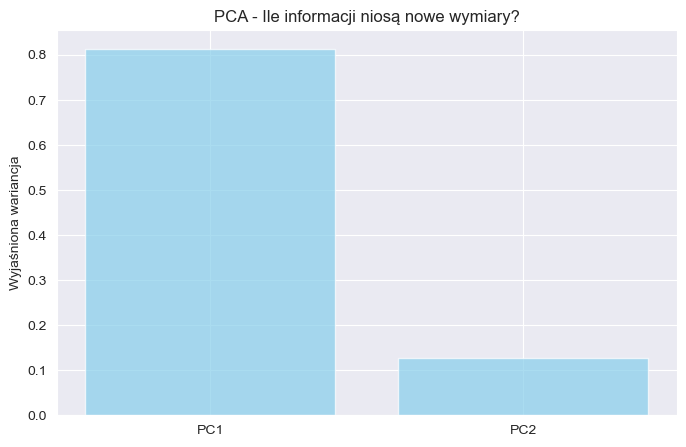

In [50]:
plt.figure(figsize=(8, 5))
plt.bar(['PC1', 'PC2'], variance_ratio, color='skyblue', alpha=0.7)
plt.title('PCA - Ile informacji niosą nowe wymiary?')
plt.ylabel('Wyjaśniona wariancja')
plt.show()

In [51]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(rfm_scaled)


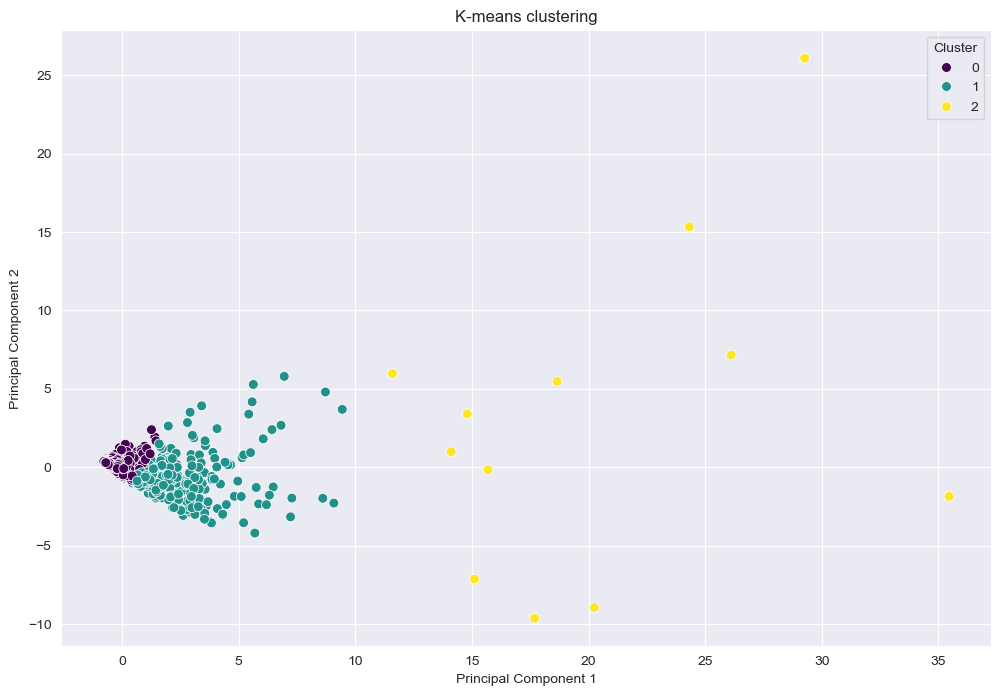

In [41]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=customer_data, palette='viridis', s=50)
plt.title('K-means clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [42]:
print(f"Cluster characteristics:")
print(customer_data.groupby('Cluster')[['Frequency', 'Monetary', 'Variety']].mean())

Cluster characteristics:
          Frequency       Monetary     Variety
Cluster                                       
0          2.790867     977.054166   39.711429
1         12.495840    6353.281774  196.138103
2        114.666667  116466.955000  799.833333


In [53]:
basket_data = df[df['Country'] == 'France']
basket = (basket_data.groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0).set_index('Invoice'))

basket_sets = basket.applymap(lambda x: 1 if x >= 1 else 0)
if 'POSTAGE' in basket_sets.columns: basket_sets.drop('POSTAGE', inplace=True, axis=1)

C:\Users\mateuszlamla\AppData\Local\Temp\ipykernel_21812\2582464806.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x >= 1 else 0)


In [56]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

print("\n[Apriori] Przykładowe silne reguły:")
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False).head(5)


[Apriori] Przykładowe silne reguły:


C:\Users\mateuszlamla\miniconda3\envs\SEMESTR5\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
29,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.101695,0.750000,6.103448
28,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.101695,0.827586,6.103448
4,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.072034,0.531250,5.970238
5,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.072034,0.809524,5.970238
2,(CIRCUS PARADE LUNCH BOX ),(SPACEBOY LUNCH BOX ),0.088983,0.750000,5.531250


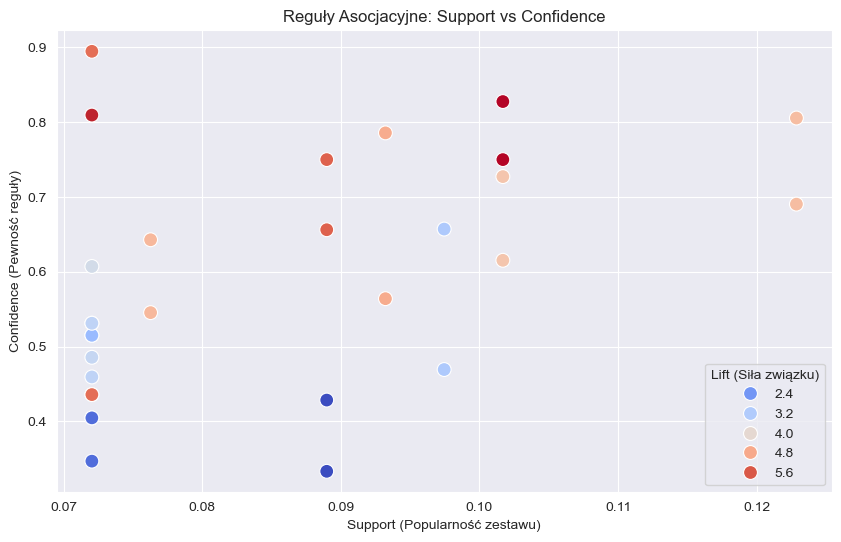

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rules['support'], y=rules['confidence'], hue=rules['lift'], palette='coolwarm', s=100)
plt.title('Reguły Asocjacyjne: Support vs Confidence')
plt.xlabel('Support (Popularność zestawu)')
plt.ylabel('Confidence (Pewność reguły)')
plt.legend(title='Lift (Siła związku)')
plt.show()